In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import custom_object_scope
import cv2
import matplotlib.pyplot as plt

# Custom ChessboardLayer definition
class ChessboardLayer(Layer):
    def __init__(self, **kwargs):
        kwargs.pop("dynamic", None)
        super().__init__(**kwargs)

    def call(self, inputs, *args, **kwargs):
        batch, row, column, channel = inputs.shape
        batch_spl = tf.split(inputs, batch, axis=0)
        for idx in range(len(batch_spl)):
            row_spl = tf.split(batch_spl[idx], 8, axis=1)
            for i in range(len(row_spl)):
                cow_spl = tf.split(row_spl[i], 8, axis=2)
                for j in range(len(cow_spl)):
                    cow_spl[j] = tf.reshape(cow_spl[j], (1, 1, 1, -1))
                row_spl[i] = tf.concat(cow_spl, axis=1)
            batch_spl[idx] = tf.concat(row_spl, axis=2)
        out = tf.concat(batch_spl, axis=0)
        return out

    def compute_output_shape(self, input_shape):
        batch, row, column, channel = input_shape
        return tf.TensorShape((batch, 8, 8, row * column * channel // 64))


# File paths for models
det_pieces_path = r"C:\Users\la7tim\Downloads\det_pieces.h5"
det_board_path = r"C:\Users\la7tim\Downloads\det_boards.h5"

# Load models within custom_object_scope
with custom_object_scope({'ChessboardLayer': ChessboardLayer}):
    det_pieces = tf.keras.models.load_model(det_pieces_path)
    det_board = tf.keras.models.load_model(det_board_path)

# Preprocessing function
def preprocess_image(image_path, target_size=(512, 512)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to detect pieces
def detect_pieces(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = det_pieces.predict(preprocessed_image)
    print(f"Model det_pieces predictions: {predictions}")
    return predictions

# Function to detect board state
def detect_board_state(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = det_board.predict(preprocessed_image)
    print(f"Model det_board predictions: {predictions}")
    return predictions


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
def predictions_to_fen(predictions, index_to_piece, confidence_threshold=0.5):
    # el printet el commented are debugget laya don't uncomment them pls, bon you can ama besh ijik barsha output
    #print("raw predictions shape:", predictions.shape)

    predictions = predictions[0].reshape(8, 8, -1)


    #print("Sample row predictions (raw):", predictions[0])

    board = []

    for row_idx, row in enumerate(predictions):
        fen_row = ''
        empty_count = 0

        for col_idx, square in enumerate(row):

            piece_index = np.argmax(square)
            piece_probability = square[piece_index]
            piece = index_to_piece.get(piece_index, '-')

            #print(f"row {row_idx}, Col {col_idx}: index={piece_index}, piece={piece}, probs={piece_probability:.2f}")

            if piece_probability < confidence_threshold:
                piece = '-'

            if piece == '-':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += piece

        if empty_count > 0:
            fen_row += str(empty_count)

        board.append(fen_row)

    fen = '/'.join(board)
    return fen


index_to_piece = {
    0: '-',
    1: 'P',
    2: 'R',
    3: 'N',
    4: 'B',
    5: 'Q',
    6: 'K',
}
image_to_test=r"C:\Users\la7tim\Downloads\phpCEZeh5.png"
model_det_pieces_predictions = det_pieces.predict(preprocess_image(image_to_test))

fen = predictions_to_fen(model_det_pieces_predictions, index_to_piece, confidence_threshold=0.7)
print("generated FEN:", fen)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
generated FEN: 8/8/N6B/8/N7/8/N7/N7


In [22]:
print("Predictions shape:", model_det_pieces_predictions.shape)


Predictions shape: (1, 64, 7)


In [23]:
print("Raw Predictions Shape:", model_det_pieces_predictions.shape)
print("Raw Predictions (sample):", model_det_pieces_predictions[0])


Raw Predictions Shape: (1, 64, 7)
Raw Predictions (sample): [[9.86064196e-01 1.79643245e-11 1.62877939e-07 1.39817770e-03
  2.47937692e-07 1.25369485e-02 3.43803606e-07]
 [7.49778509e-01 3.93648073e-02 6.65834732e-03 1.33268517e-02
  1.76265448e-01 9.77460854e-03 4.83142305e-03]
 [6.35534406e-01 7.47642517e-08 3.05896401e-01 2.59988865e-05
  1.21305883e-03 5.73291108e-02 8.84880990e-07]
 [6.86037123e-01 2.56655812e-02 9.42230131e-03 4.82414477e-03
  2.58790165e-01 1.03248982e-02 4.93579637e-03]
 [9.25551653e-01 3.92294446e-08 5.41812703e-02 1.09743029e-04
  6.48617279e-05 2.00922508e-02 1.96634574e-07]
 [7.09760725e-01 2.25514695e-02 2.41370616e-03 3.51097086e-03
  2.44774759e-01 1.54954819e-02 1.49294536e-03]
 [5.42106211e-01 1.48674815e-07 3.73870164e-01 9.40342361e-05
  6.86469080e-04 8.32428858e-02 9.81918191e-08]
 [9.99735177e-01 1.20780420e-13 4.57980204e-05 7.01462432e-06
  1.31168167e-06 1.33924019e-07 2.10574435e-04]
 [3.02244574e-01 1.97139325e-05 3.43428284e-04 1.80005166e-0

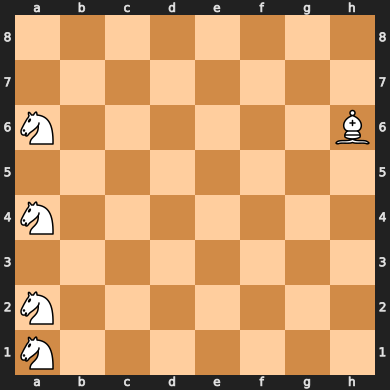

In [24]:
import chess
import chess.svg
from IPython.display import SVG, display

# Generate a chessboard visualization from the FEN
board = chess.Board(fen=fen)
svg_board = chess.svg.board(board)
display(SVG(svg_board))


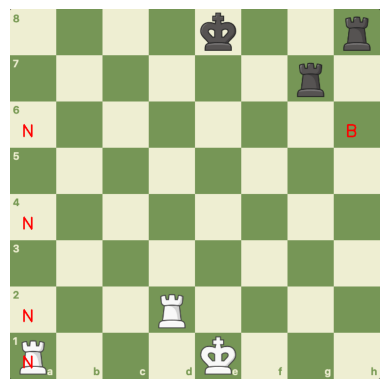

In [25]:
import cv2
import matplotlib.pyplot as plt

def overlay_predictions(image_path, fen):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    board_rows = fen.split('/')
    cell_size = image.shape[0] // 8  # Assuming square image

    for i, row in enumerate(board_rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            else:
                x = col * cell_size
                y = i * cell_size
                cv2.putText(image, char, (x + cell_size // 4, y + 3 * cell_size // 4),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                col += 1

    plt.imshow(image)
    plt.axis('off')
    plt.show()

overlay_predictions(image_to_test, fen)
